In [39]:
%pylab inline
import pandas as pd
from matplotlib import pyplot as plt
import seaborn; seaborn.set()
from ipywidgets import interact
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
scatter_args = dict(s=100, edgecolor='black', linewidth='1.5')
autumn()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Decision Trees

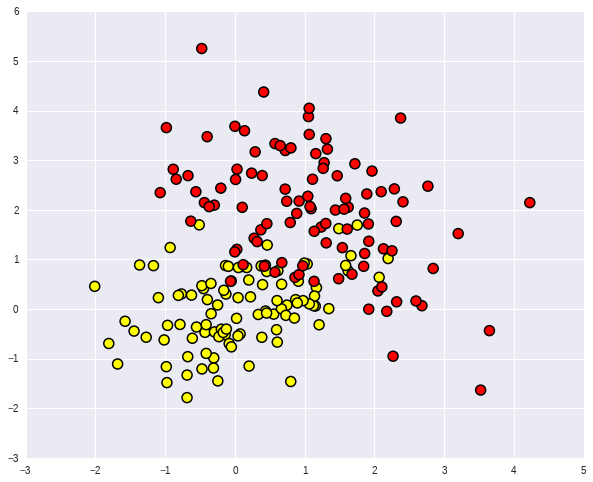

In [40]:
from sklearn.cross_validation import cross_val_score

def get_grid(data, step=0.01):
    x_min, x_max = data.x.min() - 1, data.x.max() + 1
    y_min, y_max = data.y.min() - 1, data.y.max() + 1
    return np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))

def get_score(X, y, cl):
    return cross_val_score(cl, X, y, cv=5, scoring='mean_squared_error').mean()

def show_classifier(X, y, cl,
                    feature_modifier=lambda x: x,
                    proba=True,
                    print_score=False,
                    grid=None):
    if not grid:
        xs, ys = get_grid(X)
    else:
        xs, ys = grid
    xys = c_[ravel(xs), ravel(ys)]
    cl.fit(feature_modifier(X), y)
    if print_score:
        print("MSE = {}".format(get_score(feature_modifier(X), y, cl)))
    if proba:
        predicted = cl.predict_proba(feature_modifier(pd.DataFrame(xys, columns=('x', 'y'))))[:,1].reshape(xs.shape)
    else:
        predicted = cl.predict(feature_modifier(pd.DataFrame(xys, columns=('x', 'y')))).reshape(xs.shape)
    pcolormesh(xs, ys, predicted)
    scatter(X.x, X.y, c=y, alpha=0.5, **scatter_args)
    autoscale(tight=True)
    return cl

np.random.seed(13)
n = 100

df = pd.DataFrame(
    np.vstack([
        np.random.multivariate_normal((0,0), [[1, 0.3], [0.3, 0.7]], n),
        random.multivariate_normal((1,2), [[1, -0.5], [-0.5, 1.6]], n)
    ]), columns=['x', 'y'])
df['target'] = np.hstack([np.ones(n), np.zeros(n)]).T

X = df.drop('target', axis=1)
y = df['target']

plt.scatter(df.x, df.y, c=df.target, **scatter_args);

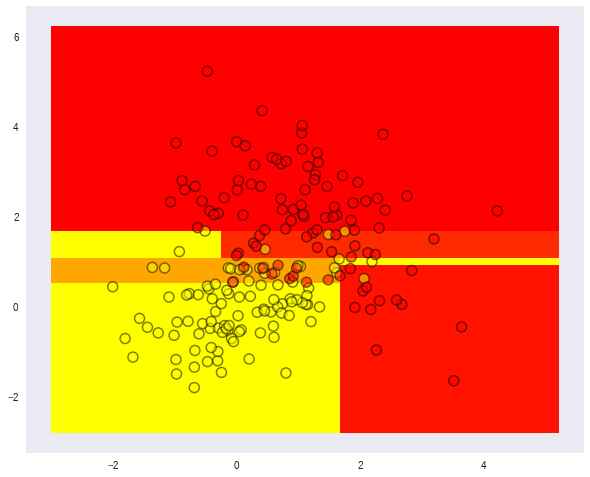

In [41]:
from sklearn.tree import DecisionTreeClassifier
simple_tree = show_classifier(X, y, DecisionTreeClassifier(max_depth=3));

In [42]:
%install_ext https://gist.githubusercontent.com/tempestadept/9322248/raw/8eb1fa343947d9628e71f10d47d1b3939a9df8a8/gvpng.py

Installed gvpng.py. To use it, type:
  %load_ext gvpng


/home/sasha/PycharmProjects/shad-ml-notebooks/env/lib/python3.4/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


In [43]:
%load_ext gvpng

The gvpng extension is already loaded. To reload it, use:
  %reload_ext gvpng


In [44]:
# Перевод дерева в графвизовский формат dot
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
from sklearn import tree
def vis_tree(cl, feature_names=['x', 'y']):
    s = StringIO()
    tree.export_graphviz(cl, out_file=s, feature_names=feature_names)
    return s.getvalue()

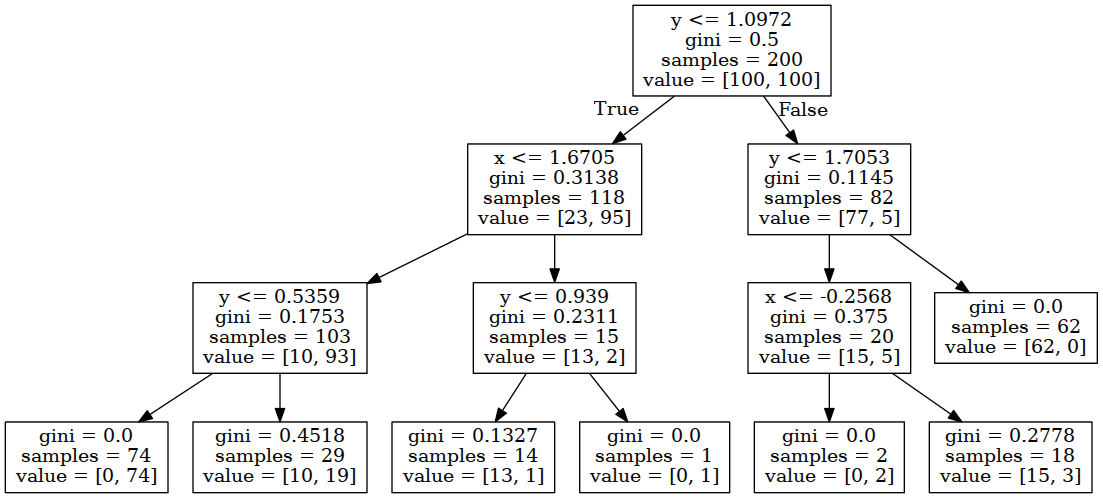

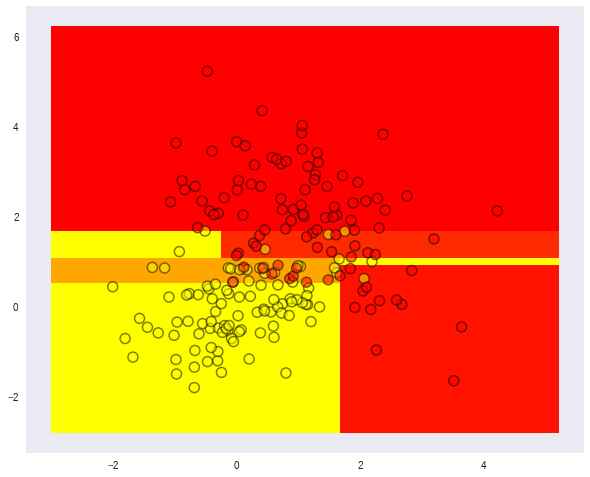

In [45]:
%dotstr vis_tree(simple_tree)
show_classifier(X, y, DecisionTreeClassifier(max_depth=3));

Misclassification Rate: $$C(j,t) = \frac{1}{n_{jt}} \sum_{y_i: x_{ij} \gt t} [y_i \ne \hat{y}]$$
Gini: $$C(j,t) = \sum_{k=1}^K p_i (1 - p_i) = 1 - \sum_{k=1}^K p_i^2$$
Entropy: $$H(p) = -\sum_i p_i log_2(p_i)$$

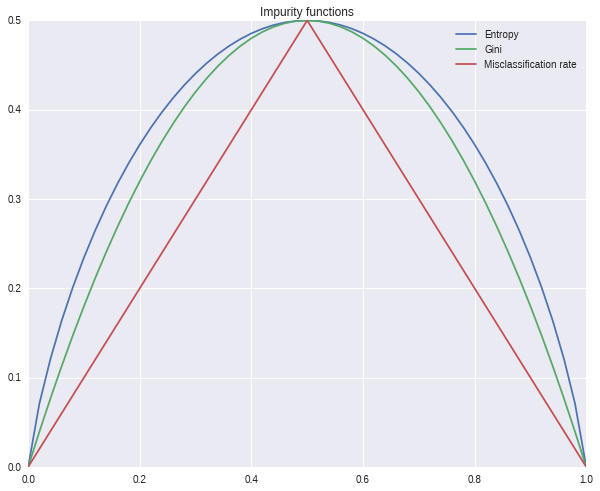

In [46]:
entropy = lambda p: -np.sum(p * np.log2(p)) if 0 not in p else 0
gini = lambda p: 1. - (np.array(p)**2).sum()
misclassification = lambda p: min(p)

pvals = np.linspace(0, 1, num=51)        
plt.plot(pvals, [entropy([p,1-p])/2. for p in pvals], label='Entropy')
plt.plot(pvals, [gini([p,1-p]) for p in pvals], label='Gini')
plt.plot(pvals, [misclassification([p,1-p]) for p in pvals], label='Misclassification rate')
plt.legend()
plt.title('Impurity functions');

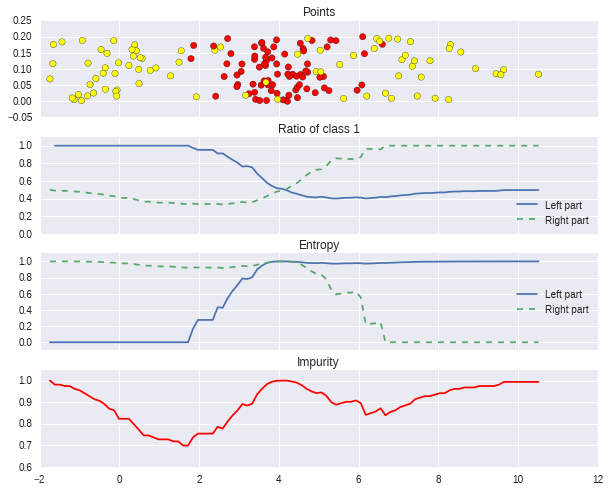

In [47]:
class_size = 80
np.random.seed(111)

points_1d = pd.DataFrame(
    {'x': np.hstack([
            np.random.normal(loc=0, scale=1, size=(class_size // 2)),
            np.random.normal(loc=4, scale=1, size=(class_size)),
            np.random.normal(loc=7, scale=2, size=(class_size // 2))
            ]),
     'label':  np.hstack([
            np.ones(class_size // 2),
            np.zeros(class_size),
            np.ones(class_size // 2)
            ])
})
f, axarr = plt.subplots(4, sharex=True)

axarr[0].set_title("Points")
axarr[0].scatter(points_1d.x, np.random.uniform(high=0.2, size=len(points_1d)), c=points_1d.label, s=40);
steps = np.linspace(np.min(points_1d.x), np.max(points_1d.x), 100)
def get_ratio_by_mask(arr, mask):
    masked = arr[mask]
    return np.sum(masked) / len(masked) if len(masked) else np.nan
ratios = np.array([np.sum(points_1d.label[points_1d.x < k]) for k in steps])

axarr[1].set_title("Ratio of class 1")
left_ratios = np.array([get_ratio_by_mask(points_1d.label, points_1d.x < k) for k in steps])
right_ratios = np.array([get_ratio_by_mask(points_1d.label, points_1d.x >= k) for k in steps])
axarr[1].plot(steps, left_ratios, label='Left part')
axarr[1].plot(steps, right_ratios, '--', label='Right part')
axarr[1].set_ylim([0, 1.1])
axarr[1].legend(loc='best')

axarr[2].set_title("Entropy")
vec_entropy = lambda p: -np.nan_to_num(p * np.log2(p) + (1 - p) * np.log2(1 - p))
left_entropy = vec_entropy(left_ratios)
axarr[2].plot(steps, left_entropy, label='Left part')
right_entropy = vec_entropy(right_ratios)
axarr[2].plot(steps, right_entropy, '--', label='Right part')
axarr[2].set_ylim([-0.1, 1.1])
axarr[2].legend(loc='best')

axarr[3].set_title("Impurity")
weights = np.array([np.sum(points_1d.x < s) for s in steps]) / len(points_1d)
impurity = weights * left_entropy + (1 - weights) * right_entropy
axarr[3].set_ylim([0.6, 1.05])
axarr[3].plot(steps, impurity, 'r', label='Right part')
lowest_impurity = np.argmin(impurity);

MSE = -0.11500000000000002


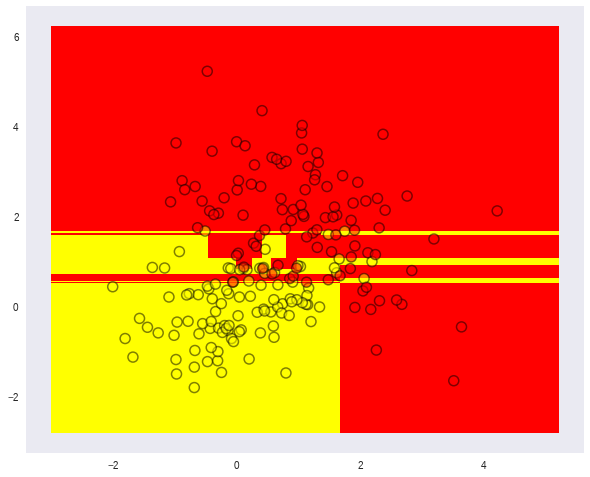

In [48]:
show_classifier(X, y, DecisionTreeClassifier(), print_score=True);

MSE = -0.095


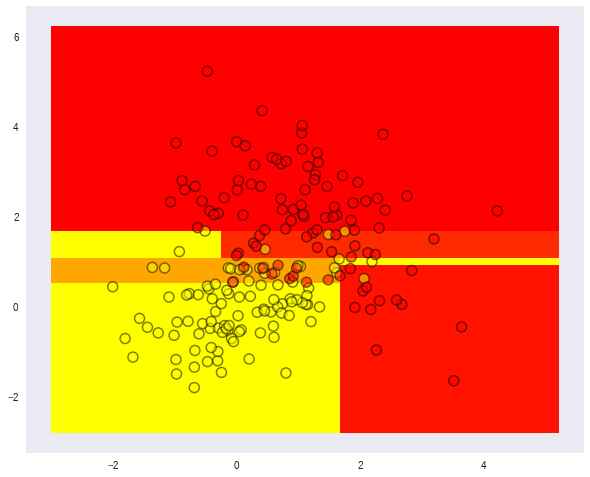

In [49]:
show_classifier(X, y, DecisionTreeClassifier(max_depth=3), print_score=True);

MSE = -0.12999999999999998


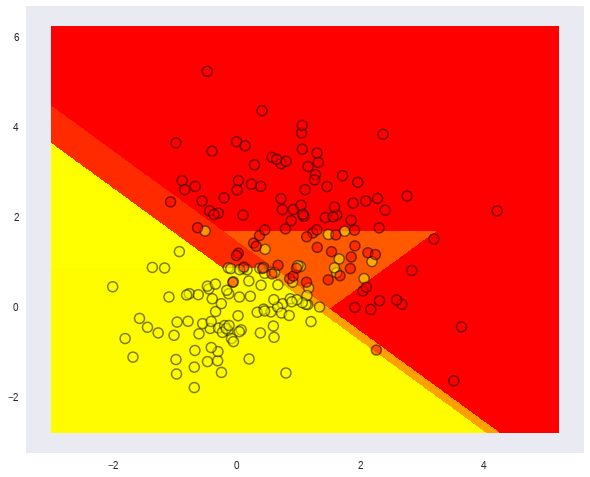

In [50]:
def add_features(X):
    return pd.concat([X, pd.DataFrame({'f1': X.x + X.y, 'f2': X.x - X.y})], axis=1)

show_classifier(X, y, DecisionTreeClassifier(max_depth=3),
                feature_modifier=add_features,
                print_score=True);

# Random forest

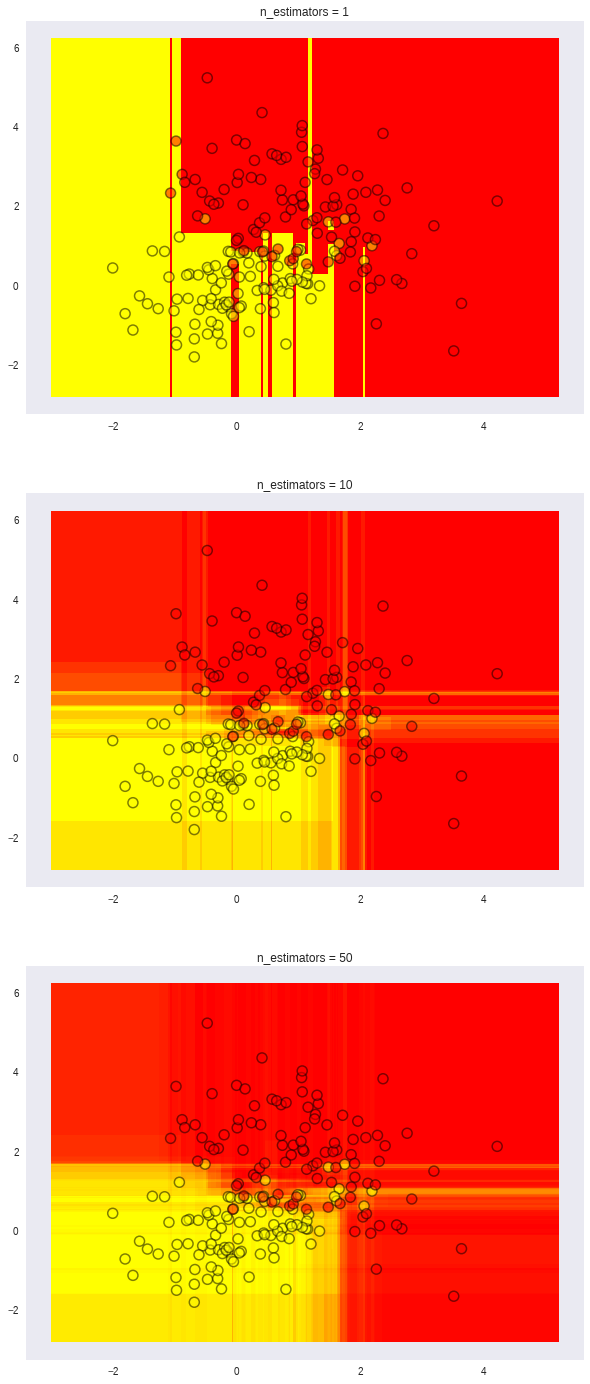

In [51]:
from sklearn.ensemble import RandomForestClassifier
n_estimators_grid = [1, 10, 50]
figure(figsize=(10, 8 * len(n_estimators_grid)))

for index, n_estimators in enumerate(n_estimators_grid):
    subplot(len(n_estimators_grid), 1, index + 1)
    show_classifier(X, y, 
                    RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1));
    title("n_estimators = {}".format(n_estimators));

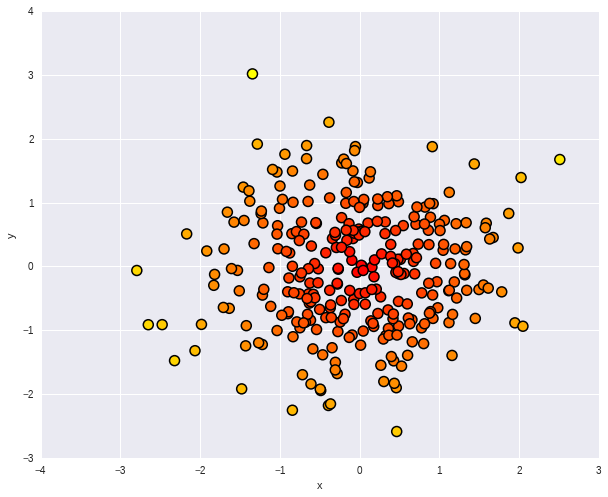

In [52]:
r_data = pd.DataFrame(np.random.normal(size=(300, 2)), columns=['x', 'y'])
r_data['target'] = (r_data.x ** 2 + r_data.y ** 2) ** 0.5
r_features = r_data[['x', 'y']]
r_data.plot(kind='scatter', x='x', y='y', c='target', colormap='autumn', colorbar=False, **scatter_args);

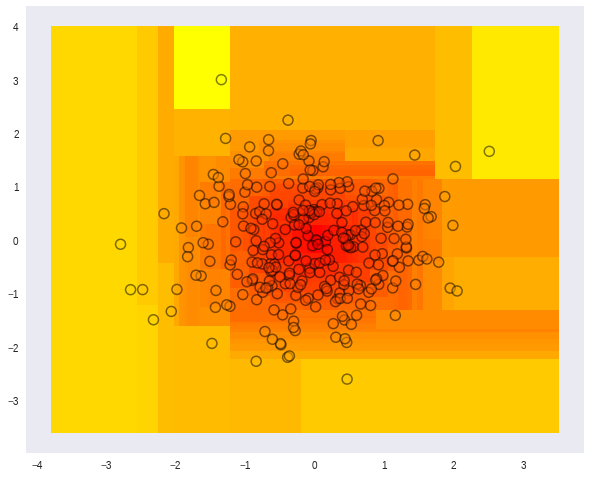

In [53]:
from sklearn.tree import DecisionTreeRegressor
show_classifier(r_features, r_data.target, 
                DecisionTreeRegressor(), proba=False);

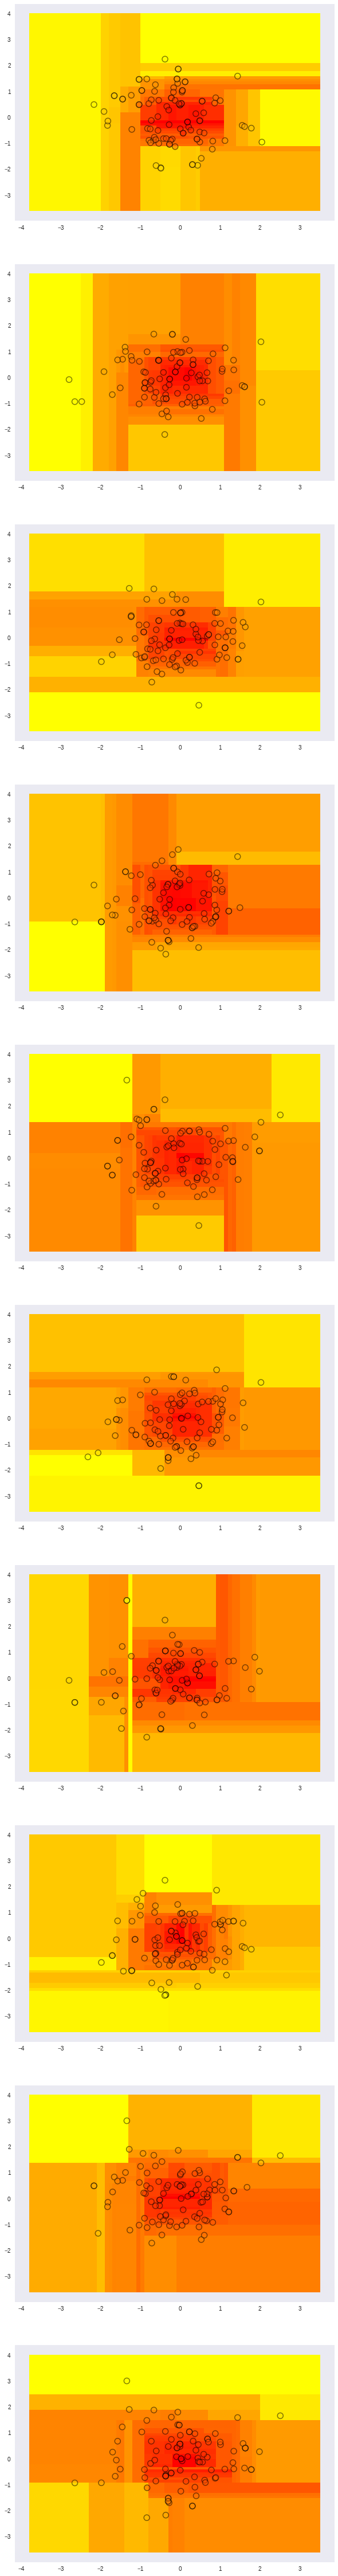

In [54]:
clfs = []
n_samples = 10
figure(figsize=(10, 8*n_samples))
sample_size = 100
grid = get_grid(r_data, 0.1)

for index in range(n_samples):
    rows = r_data.ix[np.random.RandomState(index).choice(r_data.index, sample_size)]
    subplot(n_samples, 1, index + 1)
    clfs.append(show_classifier(rows[['x', 'y']], rows.target, 
                DecisionTreeRegressor(),
                proba=False,
                grid=grid));

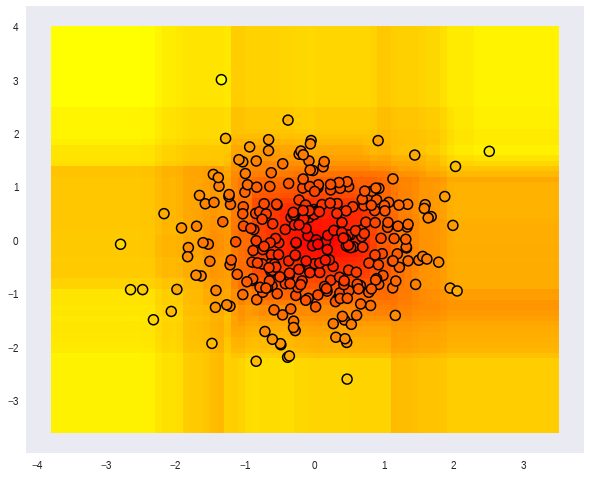

In [55]:
xs, ys = grid
xys = c_[ravel(xs), ravel(ys)]
predicted = [cl.predict(pd.DataFrame(xys, columns=('x', 'y'))).reshape(xs.shape) for cl in clfs]
pcolormesh(xs, ys, np.mean(predicted, axis=0))
scatter(r_data.x, r_data.y, c=r_data.target, **scatter_args)
autoscale(tight=True)

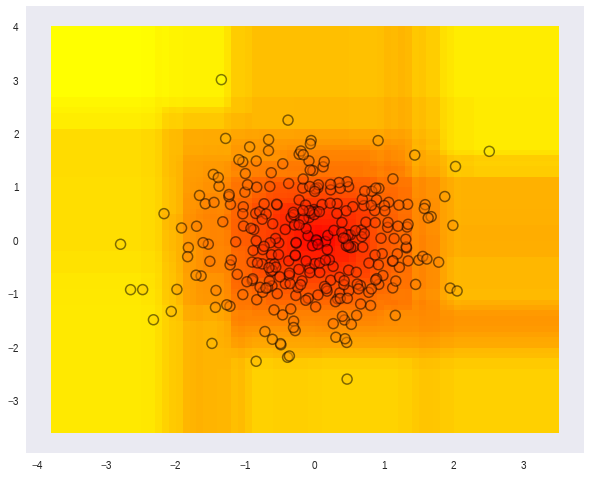

In [ ]:
from sklearn.ensemble import RandomForestRegressor
show_classifier(r_features, r_data.target, 
                RandomForestRegressor(n_estimators=10),
                proba=False,
                grid=grid);

In [ ]:
from sklearn.cross_validation import train_test_split
from itertools import chain, repeat
from sklearn.metrics import mean_squared_error

def get_plot_points(algorithm,
                    n_estimators_grid,
                    params,
                    train_features, test_features,
                    train_answers, test_answers):
    train_errors, test_errors = [], []
    for n_estimators in n_estimators_grid:
        cl = algorithm(n_estimators=n_estimators, **params)
        cl.fit(train_features, train_answers)
        train_errors.append(mean_squared_error(cl.predict(train_features), train_answers))
        test_errors.append(mean_squared_error(cl.predict(test_features), test_answers))
    return train_errors, test_errors

split = train_test_split(r_features, r_data.target, test_size=0.33, random_state=42)
train_errors_rsm, test_errors_rsm = [], []
n_estimators_grid = range(1, 361, 20)
plot(*chain(*zip(repeat(n_estimators_grid),
                 chain(get_plot_points(RandomForestRegressor, n_estimators_grid, {'n_jobs' : -1}, *split),
                       get_plot_points(RandomForestRegressor, n_estimators_grid, {'n_jobs' : -1, 'max_features' : 1}, *split)
                       ),
                 ['r-', 'b-', 'r--', 'b--'])));
legend(('Bagging (train)', 'Bagging (test)',
        'Bagging + RSM (train)', 'Bagging + RSM (test)'));

In [ ]:
from sklearn.ensemble import RandomForestClassifier
n_estimators_grid = [1, 10, 50]
figure(figsize=(10, 8 * len(n_estimators_grid)))

for index, n_estimators in enumerate(n_estimators_grid):
    subplot(len(n_estimators_grid), 1, index + 1)
    show_classifier(X, y, 
                    RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1),
                    print_score=True);
    title("n_estimators = {}".format(n_estimators));

# Links

- http://scikit-learn.org/stable/modules/tree.html
- https://github.com/tmadl/sklearn-expertsys
- A Compact and Accurate Model for Classification, Mark Last, Oded Maimon
- http://stackoverflow.com/questions/22722730/installing-pygraphviz-on-windows-python-2-7-graphviz-2-36